In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #192: KMP_AFFINITY: 1 socket x 8 cores/socket x 1 thread/core (8 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 2 maps to socket 0 core 2 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 3 maps to socket 0 core 3 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 4 maps to socket 0 core 4 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 5 maps to socket 0 core 5 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 6 maps to socket 0 core 6 thread 0 
OMP: Info #172: KMP_AFFINITY: OS pr

In [4]:
from samples.mapillary import mapillary

In [5]:
%matplotlib inline

In [6]:
# Конфигурации

In [7]:
config = mapillary.MapillaryConfig()
config.MINI_MASK_SHAPE = (32, 32)

In [8]:
MAPILLARY_DIR = "/home/mario/mapilary-vistas/mapillary_25"

# Преглед на данните

### Информация за класовете изображения

In [9]:
dataset = mapillary.MapillaryDataset()
dataset.load_mapillary(MAPILLARY_DIR, "training")

dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

There are 66 labels in the config file
                          Bird ( 0): animal--bird                             has instances: True
                 Ground Animal ( 1): animal--ground-animal                    has instances: True
                          Curb ( 2): construction--barrier--curb              has instances: False
                         Fence ( 3): construction--barrier--fence             has instances: False
                    Guard Rail ( 4): construction--barrier--guard-rail        has instances: False
                       Barrier ( 5): construction--barrier--other-barrier     has instances: False
                          Wall ( 6): construction--barrier--wall              has instances: False
                     Bike Lane ( 7): construction--flat--bike-lane            has instances: False
             Crosswalk - Plain ( 8): construction--flat--crosswalk-plain      has instances: True
                      Curb Cut ( 9): construction--flat--curb-cut        

Преглед на маските за няколко изображения

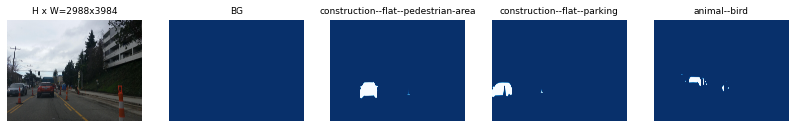

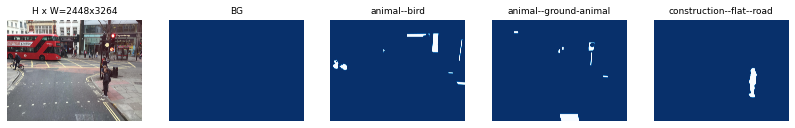

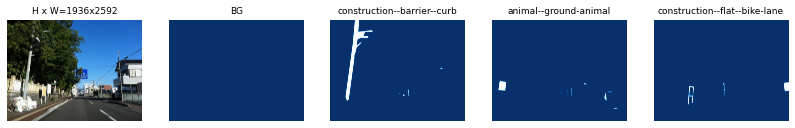

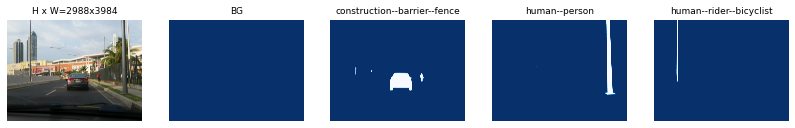

In [10]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Ограждащи кутии

Изчисляваме ограждащите кутии от маските на изображенията

image_id  15 /home/mario/mapilary-vistas/mapillary_25/training/images/GPGF4y4HOzllltRJcaJ6ew.jpg
image                    shape: (2448, 3264, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2448, 3264, 15)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (15,)                 min:    0.00000  max:   14.00000  uint8
bbox                     shape: (15, 4)               min:    0.00000  max: 3264.00000  int32


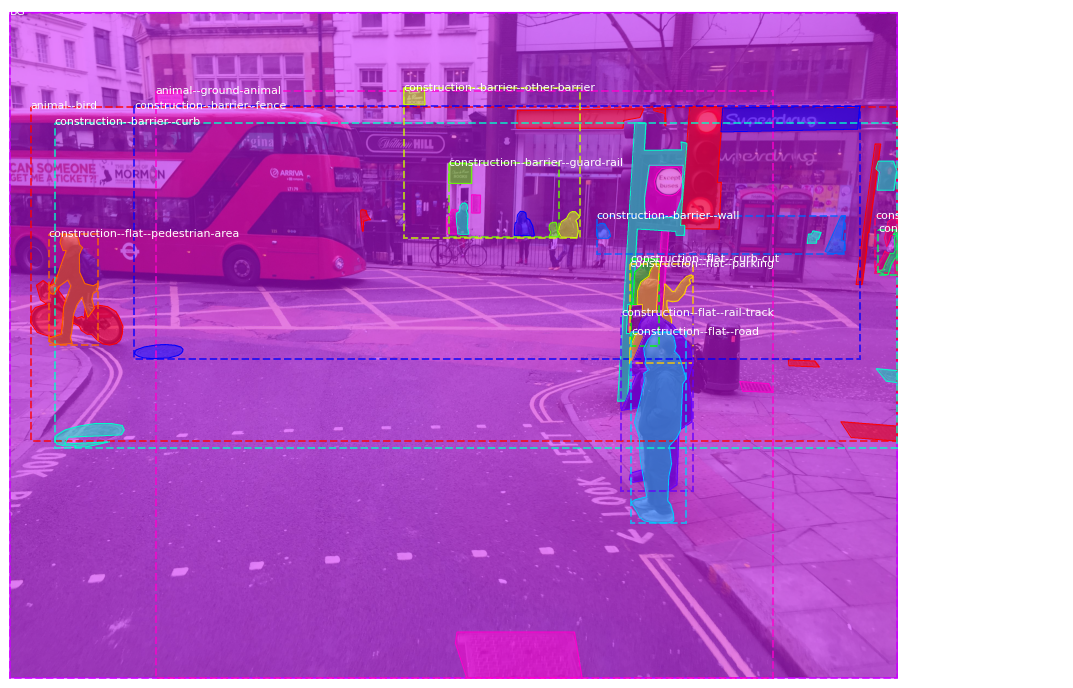

In [11]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Преоразмеряване

За да поддържаме няколко изображения в партида на трениране, преоразмеряваме изображенията до 1024 x 1024. Запазваме съотношенията в размерите и понеже изображенията не са квадратни, допълваме с нули отгоре/отдолу.

image_id:  18 /home/mario/mapilary-vistas/mapillary_25/training/images/r48A5R7_igQFjugaWei2ig.jpg
Original shape:  (2160, 3840, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 27)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (27,)                 min:    2.00000  max:   65.00000  uint8
bbox                     shape: (27, 4)               min:    0.00000  max: 1024.00000  int32


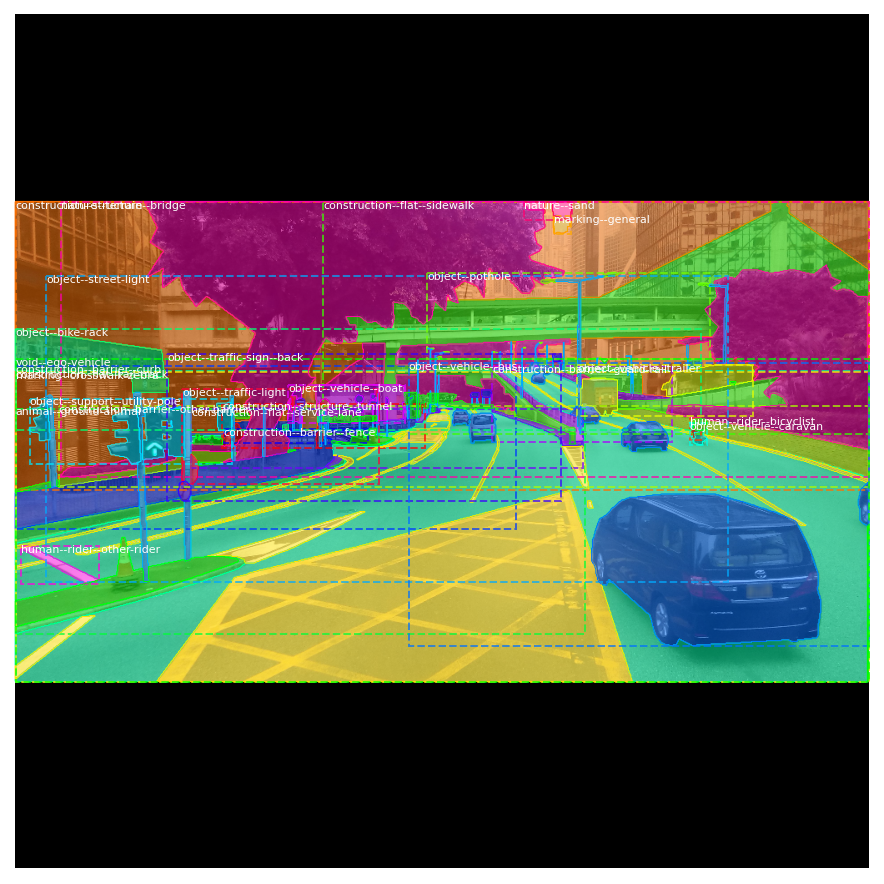

In [23]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Компактни маски

Бинарните маски за инстанции могат да станат доста големи при изображения с висока резолюция - 
при текущия размер от 1024 x 1024 една маска заема 1 MB. За да повишим скоростта на трениране оптимизираме 
като съхраняваме маските само на обектите, а не на цялото изображение което е особено полезно понеже повечето 
обекти заемат доста малка част от изображението. Преоразмеряваме маските до по-малък размер, 
което причинява загуба на прецизност, но понеже анотациите обикновено не са изключително прецизни това приемливо за практически цели.
Визуализираме примери, за да покажем ефекта от преоразмеряването.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (79,)                 min:    0.00000  max: 4032.00000  float64
class_ids                shape: (23,)                 min:    2.00000  max:   65.00000  uint8
bbox                     shape: (23, 4)               min:    0.00000  max: 1024.00000  int32
mask                     shape: (1024, 1024, 23)      min:    0.00000  max:    1.00000  bool


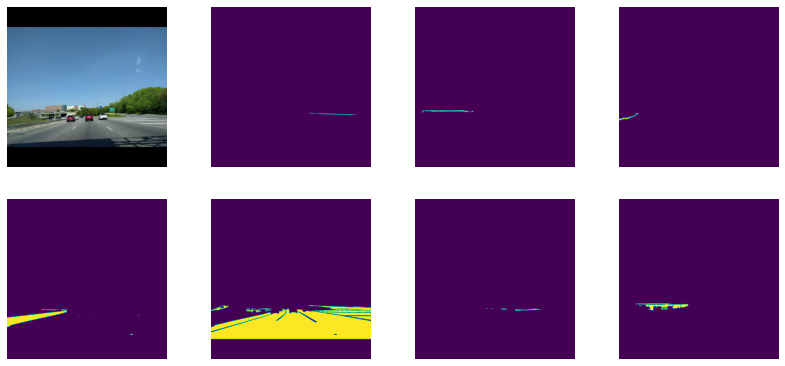

In [24]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

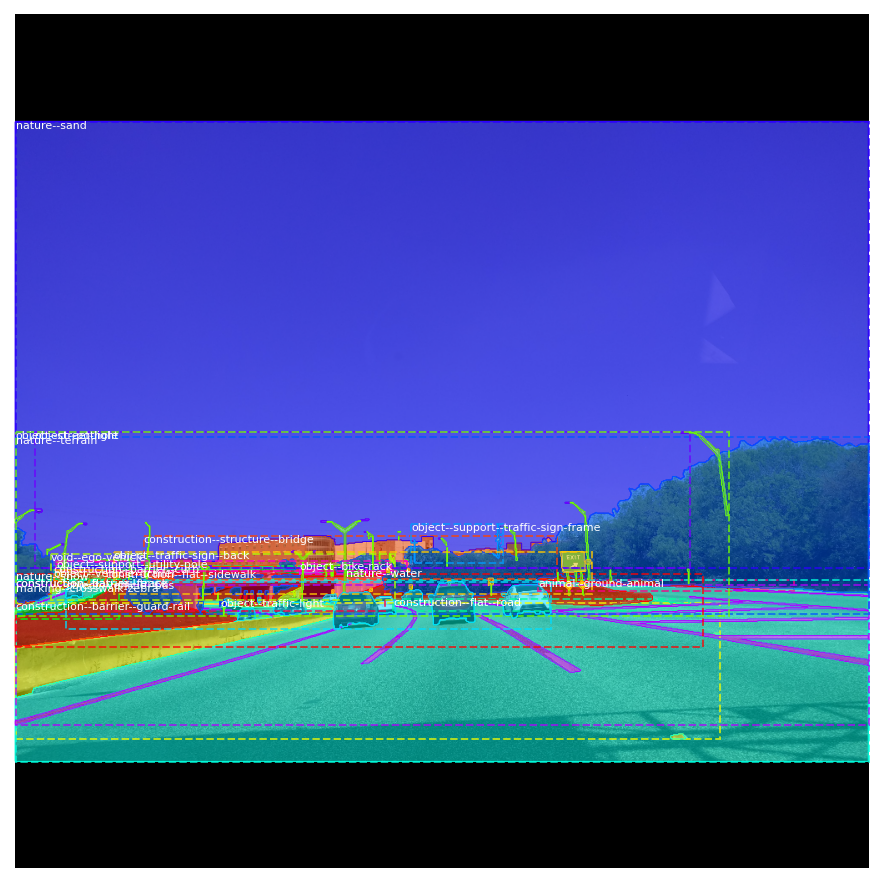

In [25]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

Обогатяване на изображението(augmentation) и преоразмеряване на маските

In [12]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

ValueError: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.

In [13]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

ValueError: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.

In [ ]:
Anchors
The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts.

Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.
Anchor Stride: In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (2562563). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.

In [14]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


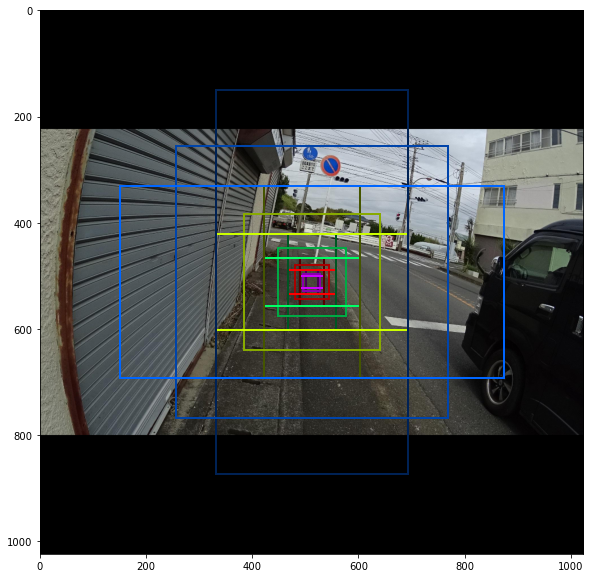

In [17]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = 1
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [18]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [19]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

ERROR:root:Error processing image {'id': 'PXN_F4bCIbRvl_ZE6Wnrjg', 'source': 'mapillary', 'path': '/home/mario/mapilary-vistas/mapillary_25/training/images/PXN_F4bCIbRvl_ZE6Wnrjg.jpg', 'width': 3264, 'height': 2448, 'instance': array([[[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
 

ERROR:root:Error processing image {'id': '_7zhntDU5r1EmkFSuzKxaQ', 'source': 'mapillary', 'path': '/home/mario/mapilary-vistas/mapillary_25/training/images/_7zhntDU5r1EmkFSuzKxaQ.jpg', 'width': 3984, 'height': 2988, 'instance': array([[[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
 

ValueError: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type.

In [20]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

NameError: name 'normalized_images' is not defined